__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пн 08 июл 2024 14:44:19 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_flat.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

38247

,title,address,latitude,longitude,priceM,dt
36482,"квартира-студия, 28,3 м², 2/9 эт.","севастополь,жк «доброгород» улица токарева,8 этап,блок 3",44.58,33.51,5.01,2024-06-10
35321,"1-к. квартира, 44 м², 5/6 эт.","севастополь,улица комбрига потапова,37 к4",44.57,33.46,7.30,2024-06-13
9749,"2-комн. квартира, 54 м², 8/12 этаж","севастополь,р-н ленинский,мкр.острякова,проспект генерала острякова,142",44.57,33.52,7.30,2024-06-10


In [4]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# df[ (df['place']=='sevastopol') & (df['address'].str.match(r'.*Судак.*')) ][cols]

---

In [5]:
df_ = pd.read_pickle('data/2023/data_flat.pkl').rename(columns={'adr':'address'})
display( len(df_) )
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page','cian_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

108483

85199

,title,address,latitude,longitude,priceM,dt,url
10731,"1-к. квартира, 40 м², 2/5 эт.","Севастополь, улица Бориса Михайлова, 3",44.583795,33.443739,5.50,2022-09-01,https://avito.ru/2504981067
72112,"2-к. квартира, 63,1 м², 2/5 эт.","Севастополь,Балаклава, улица Кирова, 20",44.500089,33.602346,12.40,2022-11-15,https://avito.ru/2265851742
43027,"3-к. квартира, 71,7 м², 2/5 эт.","Севастополь, улица Героев Бреста, 21",44.582035,33.444557,9.88,2022-09-16,https://avito.ru/2483067838


In [6]:
def address_filter(df):
    #           46.319437, 33.911048
    #
    # 45.402617, 32.455625 |  45.545301, 36.684702
    #
    #          44.320887, 33.917013

    df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
    df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

    df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 

    df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

    df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
    df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

    df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
    df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

    df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
    df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

    df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
    df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
    df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

    df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
    df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
    df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

    df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
    df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

    df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

    df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
    df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
    df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
    df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
    df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'
    df.loc[ df['address'].str.lower().str.match(r'.*симферопольский район.*'), 'place' ] = 'simferopol'

    df = df.dropna(subset=['latitude','longitude'])
    
    return df

In [7]:
df_ = address_filter(df_)
history_date = df_['dt'].max()
df = pd.concat([df,df_])
display( len(df) )
del df_

123431

----

In [8]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

In [9]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

123431

123431

----

In [10]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

123431

85821

85821

In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt,url
24976,"2-к. квартира, 76,3 м², 2/8 эт.","судак,жк «долина роз» кв-л долина роз,1 оч.",44.87,34.95,14.23,2024-06-17,https://www.avito.ru/3614088841
37108,"2-к. квартира, 94 м², 5/5 эт.","Севастополь, улица Вакуленчука, 53/10",44.58,33.48,12.00,2022-09-13,https://avito.ru/2250163604
84948,"3-к. квартира, 69,4 м², 5/5 эт.","Севастополь, улица Тараса Шевченко, 46",44.57,33.46,9.50,2024-06-05,https://avito.ru/3703851914


---

In [12]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
# display( dt_min,history_date,dt_max )
print( dt_min,' : ',dt_max )

2022-08-26  :  2024-07-08


In [13]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [14]:
# display( len(gdf_history) )
display( len(gdf) )

85821

In [15]:
display( len(gdf) )
gdf = (
    gdf
    .query("place in ('sevastopol','sudak')")
    .drop_duplicates(['dt','url'])
    .reset_index(drop=True)
)
display( len(gdf) )

85821

85821

# общая статистика

In [16]:
gdf[['title','address','priceM','geometry']].sample(1024).explore()

In [17]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(1024).explore()

In [18]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [19]:
# gdf_last[ gdf_last['address'].str.match(r'.*долина роз.*') ][['title','address','priceM','geometry','url']].explore()

---

In [20]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        gdf
        .groupby(['place','nrooms','week'])
#         .groupby(['place','nrooms','month'])
        ['priceM'].describe(percentiles=percentiles)
    )
    
display( stat )

count  mean  std  min   1%   5%  \
place      nrooms week                                                      
sevastopol 1      2022-08-22/2022-08-28 1203.00  6.26 1.91 1.59 2.31 3.70   
                  2022-08-29/2022-09-04 4734.00  6.31 1.90 1.30 2.75 3.72   
                  2022-09-05/2022-09-11 4499.00  6.32 1.91 1.60 2.80 3.72   
                  2022-09-12/2022-09-18 4435.00  6.32 1.89 1.60 2.20 3.70   
                  2022-09-19/2022-09-25 2346.00  6.29 1.92 1.35 2.25 3.60   
...                                         ...   ...  ...  ...  ...  ...   
sudak      3      2024-06-03/2024-06-09   27.00 10.05 4.90 3.50 3.53 3.72   
                  2024-06-10/2024-06-16  112.00 11.15 5.97 3.50 3.50 3.60   
                  2024-06-17/2024-06-23   56.00 11.14 5.98 3.50 3.50 3.60   
                  2024-06-24/2024-06-30   32.00 10.68 5.77 3.60 3.72 4.17   
                  2024-07-08/2024-07-14   39.00 10.09 5.25 3.60 3.75 4.27   

                                         10%  25%  50%   75%   90%   95%   max  
place      nrooms week                                                          
sevastopol 1      2022-08-22/2022-08-28 4.07 5.00 6.00  7.30  8.50  9.54 18.50  
                  2022-08-29/2022-09-04 4.16 5.02 6.00  7.40  8.60  9.70 18.50  
                  2022-09-05/2022-09-11 4.15 5.05 6.00  7.40  8.70  9.78 18.50  
                  2022-09-12/2022-09-18 4.24 5.10 6.00  7.35  8.55  9.70 18.50  
                  2022-09-19/2022-09-25 4.20 5.10 6.00  7.30  8.50  9.70 18.50  
...                                      ...  ...  ...   ...   ...   ...   ...  
sudak      3      2024-06-03/2024-06-09 4.27 8.00 9.50 11.65 15.00 20.03 23.63  
                  2024-06-10/2024-06-16 4.07 8.50 9.60 13.00 21.49 23.63 30.00  
                  2024-06-17/2024-06-23 4.35 8.50 9.60 13.00 18.74 23.63 30.00  
                  2024-06-24/2024-06-30 4.70 7.58 9.70 12.20 15.27 22.83 30.00  
                  2024-07-08/2024-07-14 4.65 7.00 9.50 10.82 13.84 22.28 30.00  

[69 rows x 13 columns]

In [21]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
sizes = stat.reset_index()['nrooms'].unique()

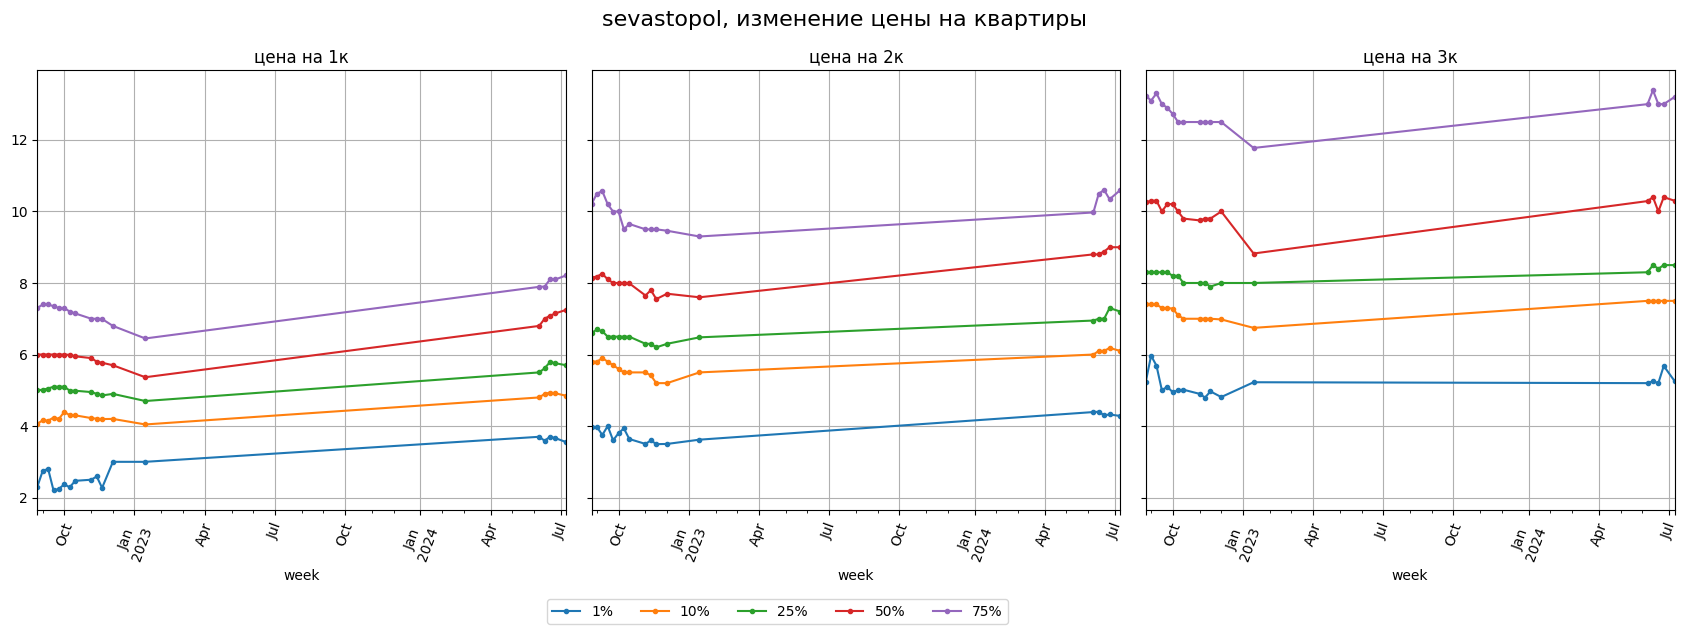

In [22]:
# history_date

place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

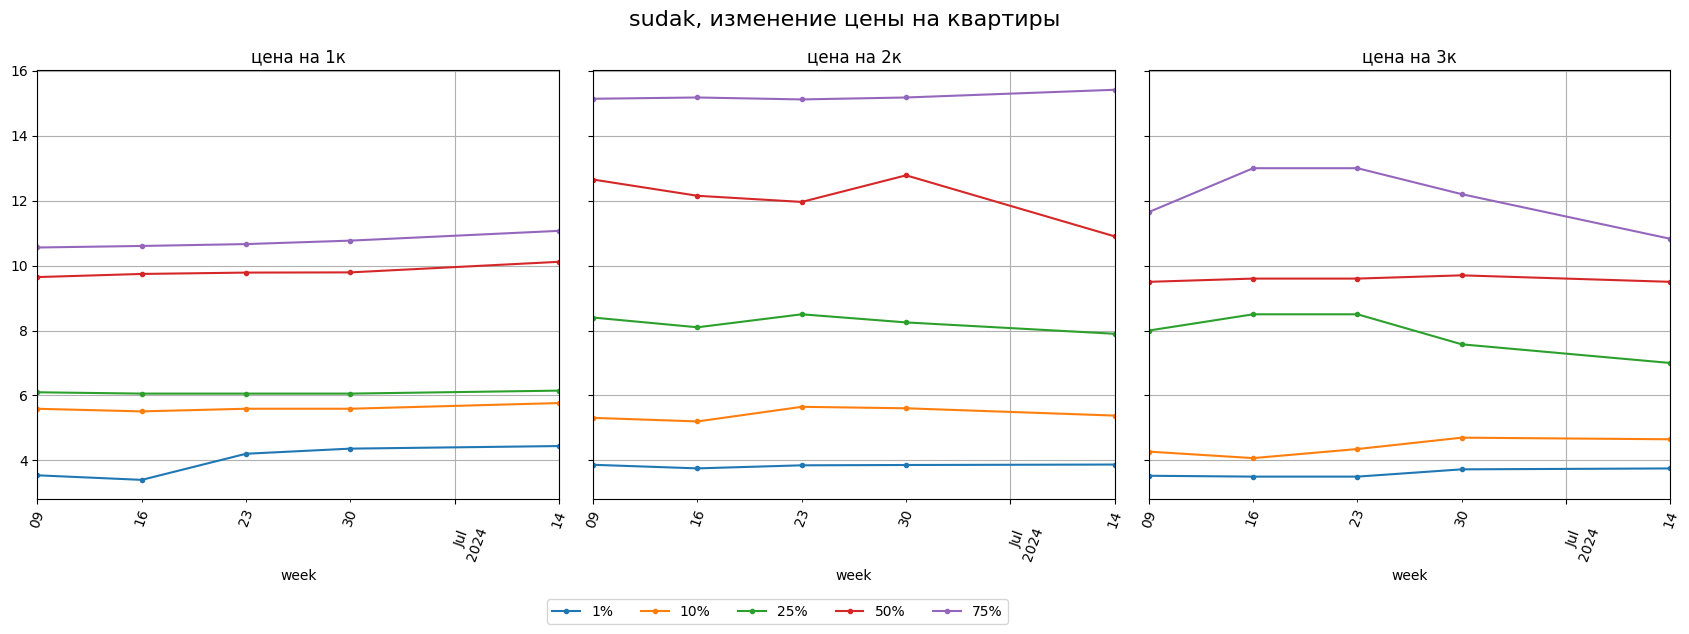

In [23]:
# history_date

place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [24]:
# sorted(gdf['dt'].unique() )

In [25]:
# dt_now = pd.to_datetime('2024-06-17').date()
dt_now = gdf['dt'].max()
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == dt_now ]
display(len(gdf_last))

85821

1968

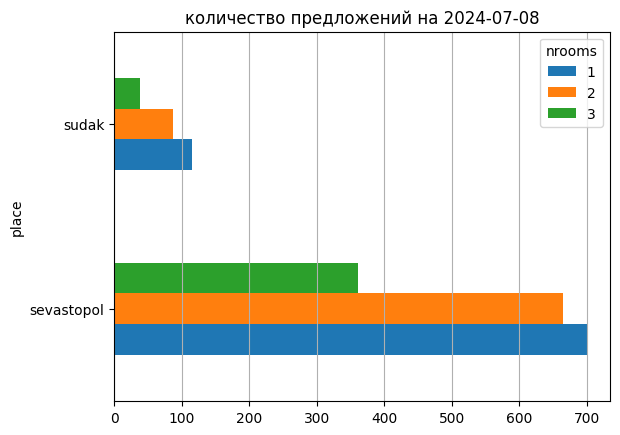

In [26]:
(
gdf_last
.drop_duplicates('url')
.groupby(['nrooms','place'])['url'].count().reset_index()
.pivot(index='place', columns='nrooms', values='url')
.plot.barh(title='количество предложений на '+ str(dt_now))
.grid(axis='x')    
)

In [27]:
(
    gdf_last
    .drop_duplicates('url')
    .groupby(['place','nrooms'])
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std  min   1%   5%  10%  25%   50%   75%  \
place      nrooms                                                          
sevastopol 1      700.00  7.34 2.36 2.80 3.55 4.50 4.85 5.70  7.25  8.21   
           2      665.00  9.43 3.65 2.60 4.28 5.61 6.10 7.20  9.00 10.60   
           3      362.00 11.95 6.25 5.00 5.26 6.95 7.50 8.50 10.30 13.20   
sudak      1      115.00  9.19 2.58 3.30 4.44 5.23 5.77 6.15 10.12 11.07   
           2       87.00 12.09 5.63 3.70 3.87 4.50 5.38 7.90 10.90 15.42   
           3       39.00 10.09 5.25 3.60 3.75 4.27 4.65 7.00  9.50 10.82   

                    90%   95%   max  
place      nrooms                    
sevastopol 1       9.80 11.28 19.71  
           2      13.50 15.50 41.00  
           3      17.68 22.00 85.00  
sudak      1      11.37 11.85 16.13  
           2      20.37 23.15 25.15  
           3      13.84 22.28 30.00

In [28]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

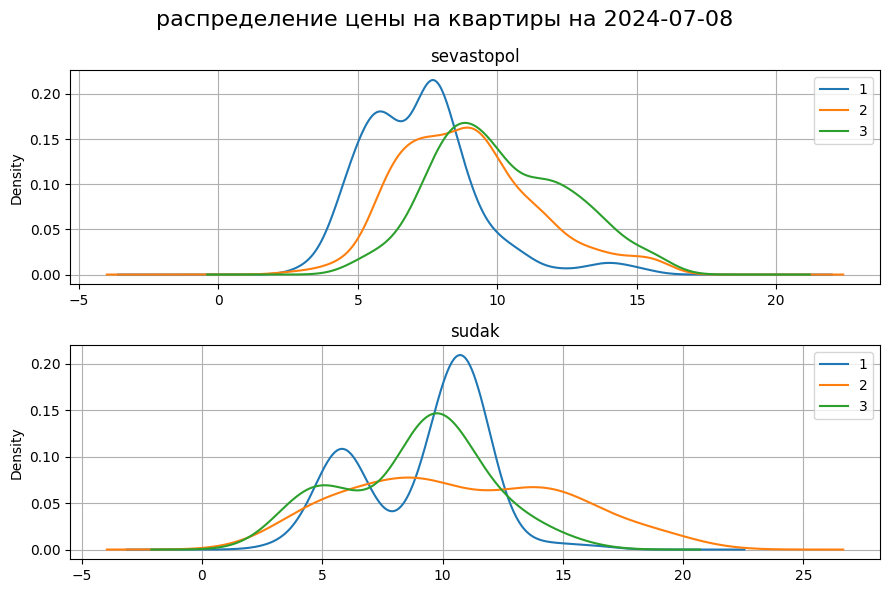

In [29]:
places = ['sevastopol','sudak',]
fig, ax = plt.subplots(len(places),1,figsize=(9,6) )
for i,p in enumerate(places): 
    (
        gdf_last
        .drop_duplicates('url')
        .query(f'(place=="{p}")&(priceM<{q_95[p]})')
        .groupby(['nrooms'],observed=True)
        ['priceM'].plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на квартиры на '+ str( gdf_last['dt'].max() ), fontsize=16)
fig.tight_layout()

# цены на карте

In [30]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [31]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

## Севастополь

In [32]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sevastopol.explore()

In [33]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    .sjoin( gdf_last.drop_duplicates('url').query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## Судак

In [34]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [35]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=9 )
grid_values = ( 
    grid
    .sjoin( 
        gdf_last
        .drop_duplicates('url')
        .query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [36]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

# display(frames)

In [37]:
frames.explore('area_name', legend=True)

In [38]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
]

In [39]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

In [40]:
# фильтруем данные по области
gdf_last_local = gdf_last.drop_duplicates('url').sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

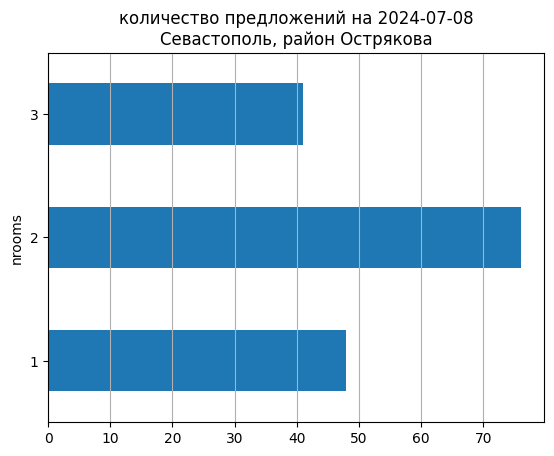

In [41]:
(
    gdf_last_local
    .drop_duplicates('url')
    .groupby(['nrooms'])['url'].count()
    .plot.barh(title='количество предложений на '+ str( dt_now ) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')   
)

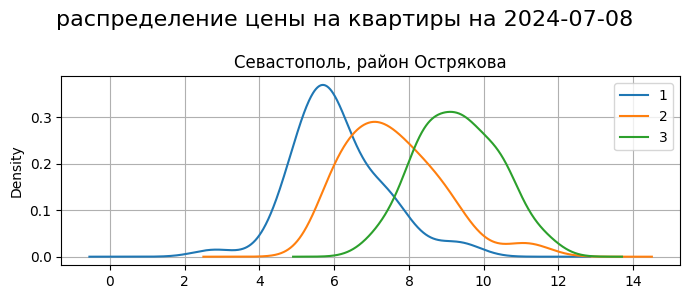

In [42]:
q_95 = gdf_last_local['priceM'].quantile(.95)

fig, ax = plt.subplots(figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    .drop_duplicates('url')
    .groupby(['nrooms'],observed=True)
    ['priceM'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
)
fig.suptitle(f'распределение цены на квартиры на '+ str( dt_now ), fontsize=16)
fig.tight_layout()

----

In [43]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [44]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf_local.groupby(['nrooms','month'],observed=True)['priceM'].describe(percentiles=percentiles)
stat = gdf_local.groupby(['nrooms','week'],observed=True)['priceM'].describe(percentiles=percentiles)
display( stat )

count  mean  std  min   1%   5%  10%  25%  50%  \
nrooms week                                                                    
1      2022-08-22/2022-08-28  90.00  5.74 1.57 1.85 1.98 3.79 4.10 4.80 5.60   
       2022-08-29/2022-09-04 397.00  5.75 1.41 1.85 1.99 3.70 4.10 4.90 5.60   
       2022-09-05/2022-09-11 359.00  5.82 1.36 1.85 2.00 3.60 4.10 5.15 5.80   
       2022-09-12/2022-09-18 380.00  5.71 1.29 1.85 2.00 3.65 4.25 4.95 5.65   
       2022-09-19/2022-09-25 209.00  5.65 1.31 1.85 2.00 3.60 4.20 4.90 5.50   
       2022-09-26/2022-10-02 101.00  5.57 1.37 1.60 1.85 3.60 4.25 4.90 5.40   
       2022-10-03/2022-10-09 111.00  5.42 1.45 1.85 2.00 3.27 4.00 4.60 5.30   
       2022-10-10/2022-10-16 119.00  5.46 1.42 1.85 2.00 3.29 4.00 4.62 5.40   
       2022-10-31/2022-11-06 191.00  5.39 1.45 1.75 1.84 2.67 4.00 4.60 5.40   
       2022-11-07/2022-11-13  99.00  5.48 1.43 1.75 1.85 3.70 4.14 4.60 5.42   
       2022-11-14/2022-11-20 101.00  5.32 1.36 1.85 1.90 3.75 4.00 4.60 5.18   
       2022-11-28/2022-12-04 109.00  5.31 1.23 1.85 2.10 3.97 4.08 4.60 5.00   
       2023-01-09/2023-01-15  64.00  5.36 1.27 1.90 2.28 3.63 4.02 4.69 5.19   
       2024-06-03/2024-06-09 163.00  5.88 1.16 2.90 2.90 4.60 4.85 5.30 5.60   
       2024-06-10/2024-06-16 232.00  5.95 1.08 2.90 2.90 4.59 4.90 5.35 5.75   
       2024-06-17/2024-06-23 115.00  6.17 1.14 2.90 3.09 4.83 4.90 5.45 6.00   
       2024-06-24/2024-06-30  58.00  6.28 1.24 2.90 3.81 4.79 4.88 5.31 6.20   
       2024-07-08/2024-07-14  48.00  6.10 1.22 2.80 3.55 4.82 4.89 5.40 5.77   
2      2022-08-22/2022-08-28 126.00  7.97 2.11 5.40 5.43 5.76 6.25 6.50 7.34   
       2022-08-29/2022-09-04 530.00  7.91 2.08 4.90 5.23 5.70 5.95 6.50 7.25   
       2022-09-05/2022-09-11 481.00  7.99 2.14 3.60 5.20 5.80 6.00 6.50 7.30   
       2022-09-12/2022-09-18 494.00  7.92 2.15 3.60 5.20 5.64 5.85 6.35 7.30   
       2022-09-19/2022-09-25 294.00  7.77 2.17 3.60 5.01 5.48 5.71 6.29 7.00   
       2022-09-26/2022-10-02 138.00  7.79 2.16 3.60 4.24 5.29 5.65 6.29 7.50   
       2022-10-03/2022-10-09 142.00  7.77 2.12 3.80 4.74 5.21 5.50 6.30 7.47   
       2022-10-10/2022-10-16 134.00  7.68 2.07 3.65 4.10 4.96 5.40 6.21 7.25   
       2022-10-31/2022-11-06 233.00  7.48 2.01 3.60 3.95 5.00 5.36 6.00 7.00   
       2022-11-07/2022-11-13 122.00  7.44 1.99 3.60 3.91 5.20 5.40 6.00 7.00   
       2022-11-14/2022-11-20 120.00  7.63 2.11 2.65 4.58 5.20 5.49 6.15 7.33   
       2022-11-28/2022-12-04 131.00  7.27 1.91 2.65 3.93 4.90 5.20 6.03 6.90   
       2023-01-09/2023-01-15  62.00  7.32 2.08 3.65 4.53 5.20 5.50 5.82 6.87   
       2024-06-03/2024-06-09 245.00  8.01 2.62 4.50 4.95 5.80 5.90 6.35 7.30   
       2024-06-10/2024-06-16 329.00  8.23 2.93 4.50 4.85 5.85 5.90 6.70 7.50   
       2024-06-17/2024-06-23 178.00  8.32 2.92 4.85 5.35 5.89 5.97 6.80 7.65   
       2024-06-24/2024-06-30  90.00  8.02 2.35 4.85 5.43 5.90 5.90 6.31 7.65   
       2024-07-08/2024-07-14  76.00  8.14 2.48 5.50 5.76 5.90 6.10 6.75 7.62   
3      2022-08-22/2022-08-28  89.00  9.62 2.37 6.90 6.90 7.00 7.30 7.80 9.00   
       2022-08-29/2022-09-04 336.00  9.54 2.26 6.90 6.90 7.00 7.30 7.80 9.00   
       2022-09-05/2022-09-11 309.00  9.80 2.44 6.15 6.81 7.20 7.30 8.00 9.00   
       2022-09-12/2022-09-18 292.00  9.72 2.41 6.15 6.65 6.96 7.21 8.00 9.00   
       2022-09-19/2022-09-25 157.00  9.69 2.33 6.15 6.46 7.00 7.30 8.00 9.00   
       2022-09-26/2022-10-02  78.00  9.56 2.25 6.50 6.65 7.19 7.30 8.00 9.00   
       2022-10-03/2022-10-09  82.00  9.40 2.16 6.50 6.58 6.91 7.00 7.82 9.00   
       2022-10-10/2022-10-16  91.00  9.50 2.31 6.50 6.50 6.80 7.00 8.00 9.00   
       2022-10-31/2022-11-06 166.00  9.61 2.30 6.20 6.20 7.00 7.15 7.93 9.00   
       2022-11-07/2022-11-13  75.00  9.48 2.32 6.20 6.27 6.90 7.30 7.89 8.70   
       2022-11-14/2022-11-20  75.00  9.27 2.28 6.10 6.17 6.90 7.00 7.79 8.50   
       2022-11-28/2022-12-04  85.00  9.60 2.46 6.00 6.25 6.92 7.29 7.75 8.97   
       2023-01-09/2023-01-15  

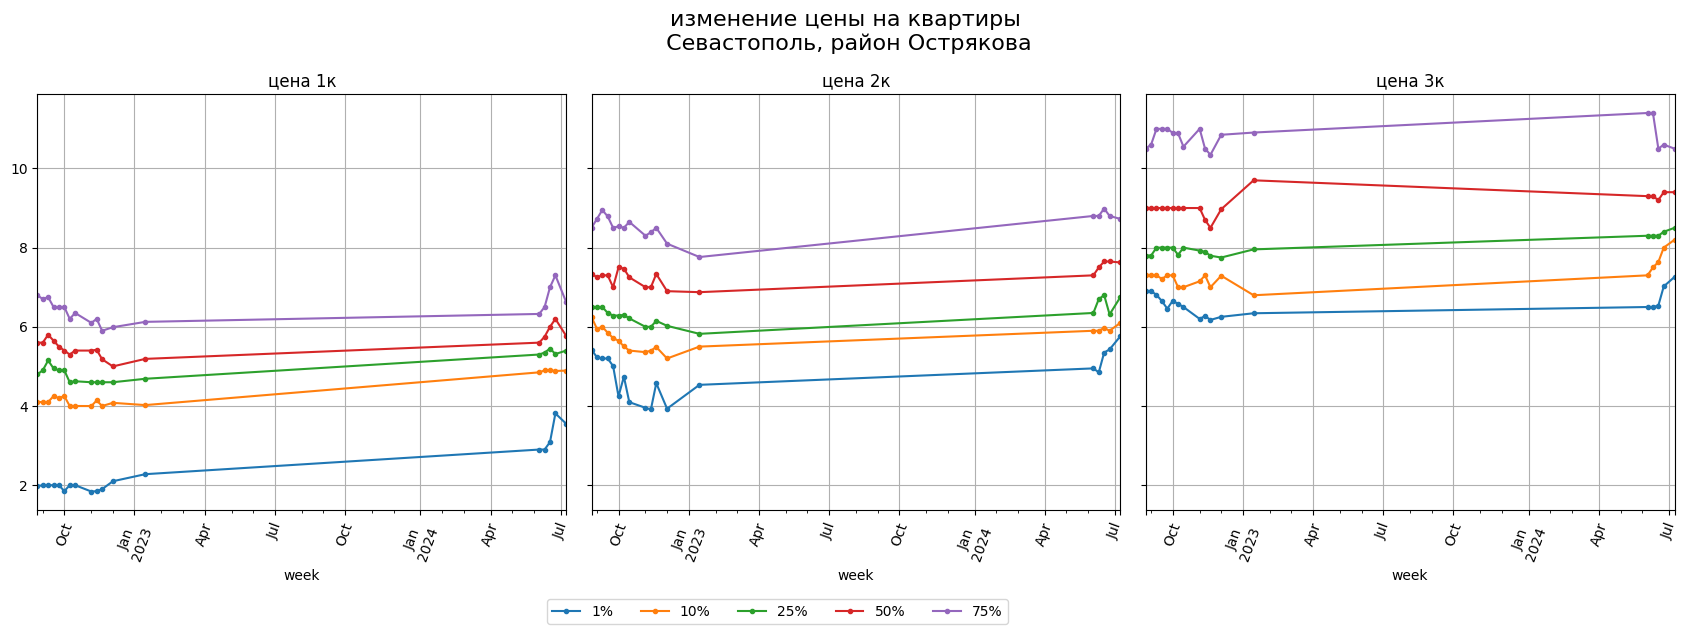

In [45]:
fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на квартиры\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [46]:
# gdf_last_local

---

In [ ]:
# df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
# df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [ ]:
# df.info()

In [ ]:
# #           46.319437, 33.911048
# #
# # 45.402617, 32.455625 |  45.545301, 36.684702
# #
# #          44.320887, 33.917013

# display( len(df) )
# df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 
# display( len(df) )
# # df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [ ]:
# df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

In [ ]:
# df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
# df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

In [ ]:
# df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
# df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

# df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
# df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

# df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
# df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

# df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
# df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

# df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
# df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

# df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

# df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
# df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
# df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
# df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
# df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'

In [ ]:
# df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkey' 
# df.loc[ df['address']=='квартал Старый Город', 'place' ] = 'turkey' 
# df.loc[ df['address'].str.lower().str.match(r'.*село радостное.*'), 'place' ] = 'belogorsk' 

In [ ]:
# display( len(df) )
# df = df.dropna(subset=['latitude','longitude'])
# display( len(df) )